In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers import AdamW, get_scheduler 
from tqdm import tqdm,trange
import numpy as np
from collections import deque, defaultdict, Counter
from copy import deepcopy
import scipy
import gc
import torch.multiprocessing as mp
import ipdb as pdb
import pickle
import os
import sys
from nltk import pos_tag, word_tokenize
import argparse
import re
import json
from analysis_utils import get_factor_stats

# CLM Model

In [2]:
class cm_model(torch.nn.Module):
    def __init__(self, model_name='gpt2-medium', cache_dir="./cache", model_type='clm', load_model=False):
        super().__init__()
        self.model_name = model_name
        self.model_type = model_type
        model_class = AutoModelForCausalLM
        self.config = AutoConfig.from_pretrained(model_name, cache_dir=cache_dir)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        
        if load_model:
            self.model = model_class.from_pretrained(model_name, from_tf=False,
                                                   config=self.config,cache_dir=cache_dir)
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.model.to(self.device)
            for p in self.model.parameters():
                p.requires_grad = False
            self.model.eval()
             
    def encode(self, context, past_key_values=None, use_cache=False, enable_grad=False, additional_truncation=0):
        wte = self.model.get_input_embeddings()
        tokens = self.tokenizer(context)
        max_len = self.model.config.n_positions-additional_truncation - 50 #for choice length
        
        if len(tokens['input_ids']) > max_len:
            print ("{} truncating {}->{}".format(context[:80], len(tokens['input_ids']), max_len))
            for k in tokens:
                tokens[k] = tokens[k][-max_len:]

        tokens = {k:torch.tensor(v).unsqueeze(0).to(self.device) for k,v in tokens.items()}
        temp = tokens['input_ids'].detach().clone()
        del tokens['attention_mask']

        inputs_embeds = wte(tokens['input_ids'])
        inputs_embeds.requires_grad = False
        outputs = self.model(inputs_embeds=inputs_embeds, return_dict=True,
                            past_key_values=past_key_values, use_cache=use_cache)

        outputs['input_ids'] = temp
        outputs['inputs_embeds'] = inputs_embeds
        return outputs
    
    def compute_nll(self, context_outputs, ch_outputs, enable_grad=True): #conditional
        with torch.set_grad_enabled(enable_grad):
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            
            labels = ch_outputs['input_ids'].contiguous()
            logits = torch.cat([context_outputs['logits'][:, -1:, :], ch_outputs['logits'][:,:-1, :]], dim=1).contiguous()
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
            prob = F.softmax(logits, 2)
                        
        outputs = {
            'prob': prob.detach().cpu().numpy(),
            'labels': labels.view(-1).detach().cpu().numpy(),
            'loss': loss.view(-1).detach().cpu().numpy(),
            'score': torch.sum(loss).item(),
        }
        return outputs

    def process_context_and_choices(self, context, choices, reduction='sum', out_tokens={}, bag=False, additional_truncation=0):
        enable_grad=False
        scores = []
        for ch_idx in range(len(choices)):
            self.model.zero_grad()
            context_outputs = self.encode(context,
                                  use_cache=True,
                                  enable_grad=enable_grad,
                                  past_key_values=None, additional_truncation=additional_truncation)

            ch_output = self.encode(choices[ch_idx],
                                    past_key_values=context_outputs['past_key_values'],
                                    enable_grad=enable_grad)

            score = self.compute_nll(context_outputs, ch_output, enable_grad=enable_grad)

            scores.append(score)

        return scores

    @torch.inference_mode()
    def score(self, example, additional_truncation=0):
        scores = [{} for _ in range(len(example['choices']))]

        #context
        temp_scores = self.process_context_and_choices(example['context'], example['choices'], additional_truncation=additional_truncation)
        for ch_idx in range(len(example['choices'])):
            scores[ch_idx]['res0'] = temp_scores[ch_idx]

        #dummy context
        temp_scores = self.process_context_and_choices(example['dummy_context'], example['choices'])
        for ch_idx in range(len(example['choices'])):
            scores[ch_idx]['res1'] = temp_scores[ch_idx]                 
        
        #save additional results
        for ch_idx in range(len(example['choices'])):
            tcal_prob2 = scores[ch_idx]['res0']['prob'] - scores[ch_idx]['res1']['prob'][:,:1,:]
            tcal_prob2 = scipy.special.softmax(tcal_prob2, axis=2)
            tcal_loss2 = tcal_prob2[:, range(tcal_prob2.shape[1]), scores[ch_idx]['res0']['labels']]
            scores[ch_idx]['res0']['tcal_loss2'] = -np.log(tcal_loss2)

            pc,pn = scores[ch_idx]['res0']['prob'][0,0,:], scores[ch_idx]['res1']['prob'][0,0,:]
            scores[ch_idx]['c_prob0'] = pc.reshape(-1)
            scores[ch_idx]['n_prob0'] = pn.reshape(-1)

            del scores[ch_idx]['res0']['prob']
            del scores[ch_idx]['res1']['prob']
            
        return scores

def predict_(scores, mode=None):
    c_scores = np.array([item['res0']['score'] for item in scores])
    n_scores = np.array([item['res1']['score'] for item in scores])
    #cprob = scores[0]['c_prob0']
    #nprob = scores[0]['n_prob0']
    cprob = np.array([item['c_prob0'] for item in scores])
    nprob = np.array([item['n_prob0'] for item in scores])
    if mode == 'alc_unscaled':
        scores = c_scores - n_scores
    elif mode == 'alc_tvd':
        #mult = 1 - 0.5 * np.sum(np.abs(cprob-nprob))
        mult = 1 - 0.5 * np.sum(np.abs(cprob-nprob), axis=1)
        scores = c_scores - mult * n_scores
    elif mode == 'alc_bc':
        #mult = np.sum(np.sqrt(cprob*nprob))
        mult = np.sum(np.sqrt(cprob*nprob), axis=1)
        scores = c_scores - mult * n_scores
    elif mode == 'uncalibrated':
        scores = c_scores
    elif mode == 'length_normalized':
        scores = np.array([np.mean(item['res0']['loss']) for item in scores])
    elif mode == 'answer_only':
        scores = n_scores
    elif mode == 'answer_only_norm':
        scores = np.array([np.mean(item['res1']['loss']) for item in scores])
    elif mode == 'answer_only_worst':
        scores = -n_scores
    elif mode == 'answer_only_worst_norm':
        scores = -np.array([np.mean(item['res1']['loss']) for item in scores])
    elif mode == 'token_calibration':
        scores = np.array([np.sum(item['res0']['tcal_loss2']) for item in scores])
    else:
        raise NotImplementedError("Mode {} not implemented".format(mode))
   
    pred_idx = np.argmin(scores)
    scores_exp = np.exp(-scores)
    conf = scores_exp[pred_idx]/np.sum(scores_exp)

    res = {
            'pred': pred_idx,
            'conf': conf
        }
    return res

def predict(scores, mode='default'):
    out = [predict_(item, mode=mode) for item in scores]
    preds = [item['pred'] for item in out]
    conf = [item['conf'] for item in out]
    info = {}
    info['conf'] = conf
    return preds, info

#for mp
def score_fn(p_rank, model, data, indices, return_dict):
    enable_grad = False
    if p_rank == 0:
        indices = tqdm(indices)
    for idx in indices:
        with torch.set_grad_enabled(enable_grad):
            b_sucesss = False
            for additional_truncation in range(0,1000,50):
                try:
                    outputs = model.score(data[idx], additional_truncation=additional_truncation)
                    b_sucesss = True
                    break
                except Exception as e:
                    excpt = e
                    pass
            if not b_sucesss:
                raise ValueError("Input too long or", excpt)
        return_dict[idx] = outputs

# Data Pre-processing 
* For the sake of this reproducibility analysis I will be using piqa dataset. You can find links for downloading the dataset below
* https://yonatanbisk.com/piqa/data/train.jsonl
* https://yonatanbisk.com/piqa/data/train-labels.lst

In [3]:
G_MASK_TOKEN = "[[[MASK]]]"
def convert_piqa(example, **kwargs):
    context = example['goal'].strip()
    if context.endswith(','):
        context = context[:-1] + '.'
    elif not context.endswith('?') and not context.endswith('.'):
        context = context + '.'
    context = context[0].upper() + context[1:]
    question = 'Question: {} Answer:'.format(context)

    choices = [example['sol1'], example['sol2']]
    choices = [ch[0].upper()+ch[1:] for ch in choices]
    label = example['label'] if 'label' in example else None

    output = {
        'context': '',
        'question': question,
        'question_masked': 'Question: {} Answer:'.format(G_MASK_TOKEN),
        'choices': choices,
        'label': label,
        'dummy_context': 'Answer:',
    }
    return output
    
def get_lines(p):
    if p.endswith('.jsonl'):
        with open(p) as f:
            jsonl_content = f.read()
        result = [json.loads(jline) for jline in jsonl_content.splitlines()]
    else:
        df = pd.read_csv(p)
        result = df.to_dict('record')
    return result

## Load_data function

In [4]:
def format_example(example, mask_token=None, tokenizer=None):
    formatted_text = {}
    if type(example['context']) is list:
        formatted_text['context'] = example['context']
    elif example['context'] == "":
        formatted_text['context'] = '{}'.format(example['question'])
    elif example['question'] == "":
        formatted_text['context'] = '{}'.format(example['context'])
    else:
        formatted_text['context'] = '{} {}'.format(example['context'], example['question'])
        
    formatted_text['choices'] = [' '+ch for ch in example['choices']]
        
    if mask_token is None:
        formatted_text['dummy_context'] = example['dummy_context']
    else: #assume mlm
        if tokenizer is None:
            raise ValueError("If mask token is used, tokenizer must be set")
        formatted_text['dummy_context'] = example['question_masked'].replace(G_MASK_TOKEN, mask_token)
    
    return formatted_text
    
def load_data(data_name, data_path='./', mask_token=None, tokenizer=None, data_config=None):
    datasets = {}
    datasets['dev'] = get_lines('piqa/dev.jsonl')
    datasets['test'] = get_lines('piqa/test.jsonl')
    datasets['train'] = get_lines('piqa/train.jsonl')
    kwargs = {}
    converted_datasets = {k:[convert_piqa(example, **kwargs) for example in v] for k,v in datasets.items()}
    processed_datasets = {k:[format_example(example, mask_token=mask_token, tokenizer=tokenizer) for example in v] for k,v in converted_datasets.items()}
    
    labels = {k:np.array([example['label'] for example in v]) for k,v in converted_datasets.items()}
    def compute_accuracy(split, preds, reduction="mean"):
        preds = np.array(preds)
        labels_for_split = labels[split]
        if reduction == "mean":
            acc = 100.0 * np.sum(preds==labels_for_split)/len(labels_for_split)
        elif reduction == "none":
            acc = (preds==labels_for_split)
        return acc
    context_lengths = {k: [len(tokenizer(item['context']).input_ids) for item in v] for k,v in processed_datasets.items()}
    return {
        'original': datasets,
        'converted': converted_datasets,
        'processed': processed_datasets,
        'acc_fn': compute_accuracy,
        'context_lengths': context_lengths
    }

## Seed everything

In [5]:
def set_seed(seed):
    import random
    import numpy as np
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Evaluation metrics

In [6]:
def get_scores(amodel, data, split, cached_output_name=None, cache_exists=False):
    D = data
    num_processes = 1

    if num_processes > 1:
        model.share_memory()
        manager = mp.Manager()
        return_dict = manager.dict()
    else:
        return_dict = {}

    processes = []
    block_size = int((len(D['processed'][split])+num_processes)/num_processes)
    indices = list(range(len(D['processed'][split])))
    for rank in range(num_processes):
        start_idx = block_size*rank
        end_idx = block_size*(rank+1)
        p_indices = indices[start_idx:end_idx]
        if num_processes == 1:
            score_fn(rank, model, D['processed'][split],
                                 p_indices, return_dict)
        else:
            p = mp.Process(target=score_fn, args=(rank, model,
                                              D['processed'][split],
                                              p_indices, return_dict))
            p.start()
            processes.append(p)

    if num_processes > 1:
        for p in processes:
            p.join()

    scores = [return_dict[idx] for idx in range(len(D['processed'][split]))]
    

    return scores

def process_model_outputs(model, data, split, scores, results_file):
    D = data
    results = defaultdict(dict)
    saved_preds = {}
    for abl in ['answer_only', 'answer_only_worst']:
        preds = predict(scores, mode=abl)[0]
        saved_preds[abl] = preds

    examples = D['converted'][split]
    factor_kwargs = {}
    factor_kwargs['tokenizer'] = model.tokenizer
    factor_kwargs['min_th'] = 25
    factor_kwargs['neutral_preds'] = saved_preds['answer_only']
    factor_kwargs['neutral_worst_preds'] = saved_preds['answer_only_worst']

    for abl in ['answer_only_norm', 'answer_only_worst_norm']:
        preds = predict(scores, mode=abl)[0]
        saved_preds[abl] = preds
    factor_kwargs['neutral_preds_norm'] = saved_preds['answer_only_norm']
    factor_kwargs['neutral_worst_preds_norm'] = saved_preds['answer_only_worst_norm']

    for abl in (['answer_only', 'answer_only_worst', 'answer_only_norm', 'answer_only_worst_norm', 'uncalibrated', 'length_normalized'] + 
                (['token_calibration'] if 'clm' == 'clm' else []) +
                ['alc_unscaled', 'alc_tvd', 'alc_bc']):

        preds, preds_info = predict(scores, mode=abl)
        saved_preds[abl] = preds
        acc = D['acc_fn'](split, preds)
        results[f'overall_{abl}'] = acc
        print_str = '{} {} {:.2f}'.format(abl, split, acc)

        print (print_str)

        for k in preds_info:
            if k in ['conf']:
                continue
            results[f'overall_{k}_{abl}'] = float(preds_info[k])

        for bias in ['longest', 'shortest']:
            factor_kwargs['bias'] = bias
            res = get_factor_stats(preds, examples, 'length', **factor_kwargs)
            results = update_results(results, abl, res, f'length_{bias}')  

        for bias in ['first']:
            factor_kwargs['bias'] = bias
            res = get_factor_stats(preds, examples, 'pos', **factor_kwargs)
            results = update_results(results, abl, res, f'pos_{bias}')  

        for bias in ['neutral', 'neutral_worst']:
            factor_kwargs['bias'] = bias
            res = get_factor_stats(preds, examples, 'lm', **factor_kwargs)
            results = update_results(results, abl, res, f'lm_{bias}')  

        for bias in ['neutral_norm', 'neutral_worst_norm']:
            factor_kwargs['bias'] = bias
            res = get_factor_stats(preds, examples, 'lm', **factor_kwargs)
            results = update_results(results, abl, res, f'lm_{bias}')  

    with open(results_file, 'w') as f:
        f.write(json.dumps(results, indent=4, sort_keys=True))

def update_results(results, abl, res, tag):
    #add two versions, one flattened for ease of comparing quickly
    results[f'qsel_{abl}_{tag}'] = res
    for k,v in res.items():
        if isinstance(v, dict):
            for kk,vv in v.items():
                resname = 'sel_{}_{}_{}_{}'.format(tag, k, kk, abl)
                results[resname] = vv
        else:
            resname = 'sel_{}_{}_{}'.format(tag, k, abl)
            results[resname] = v
    return results

# Training the CLM model

In [7]:
set_seed(42)

model = cm_model(load_model=True)
mask_token = model.tokenizer.mask_token
D = load_data('piqa', mask_token=mask_token, tokenizer=model.tokenizer)
len_fsl_pool = len(D['processed']['train'])
frng = np.random.RandomState(1)
for ep in range(1):
    fsl_name = ''
    D_fsl = D

    results_file = 'results/{}_{}_{}{}.json'.format(
        '{}'.format('piqa'),
        'gpt2-xl',
        'div',
        fsl_name
    )
    print ('results at', results_file)

    scores = get_scores(model, D_fsl, 'dev', 'cached_output', False)
    process_model_outputs(model, D_fsl, 'dev', scores, results_file)

Using mask_token, but it is not set yet.


results at results/piqa_gpt2-xl_div.json


100%|███████████████████████████████████████| 1838/1838 [02:05<00:00, 14.62it/s]


answer_only dev 62.51
answer_only_worst dev 37.49
answer_only_norm dev 61.86
answer_only_worst_norm dev 38.14
uncalibrated dev 67.19
length_normalized dev 67.46


/tmp/ipykernel_814732/3803844528.py:145: RuntimeWarning: invalid value encountered in scalar divide
  conf = scores_exp[pred_idx]/np.sum(scores_exp)


token_calibration dev 59.14
alc_unscaled dev 55.82
alc_tvd dev 67.63
alc_bc dev 66.16


# Visualizing the results

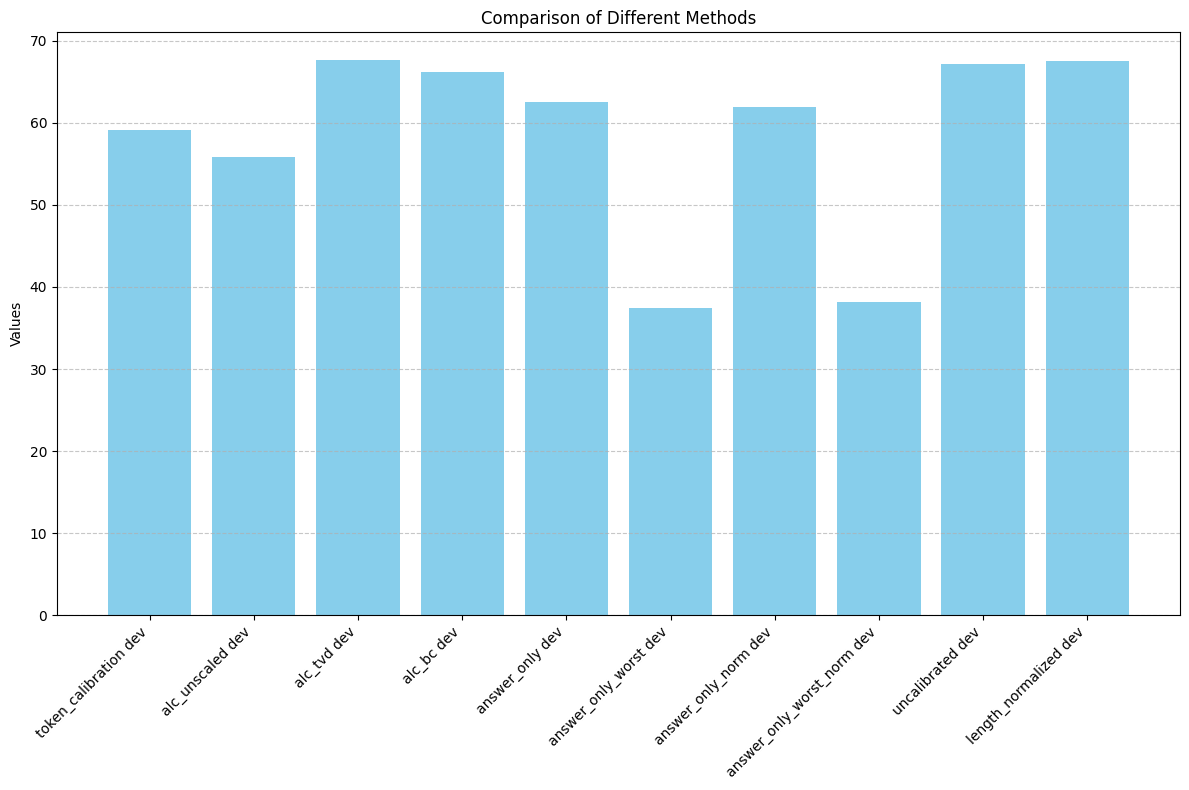

In [11]:
import matplotlib.pyplot as plt

labels = [
    "token_calibration dev",
    "alc_unscaled dev",
    "alc_tvd dev",
    "alc_bc dev",
    "answer_only dev",
    "answer_only_worst dev",
    "answer_only_norm dev",
    "answer_only_worst_norm dev",
    "uncalibrated dev",
    "length_normalized dev"
]

values = [
    59.14,
    55.82,
    67.63,
    66.16,
    62.51,
    37.49,
    61.86,
    38.14,
    67.19,
    67.46
]

plt.figure(figsize=(12, 8))
plt.bar(labels, values, color='skyblue')
plt.ylabel('Values')
plt.title('Comparison of Different Methods')
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
